 Upload your Iris CSV file (Iris.csv)


Saving archive (2).zip to archive (2) (3).zip

 Dataset Loaded Successfully!


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa



 Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB

 Missing values:
Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64


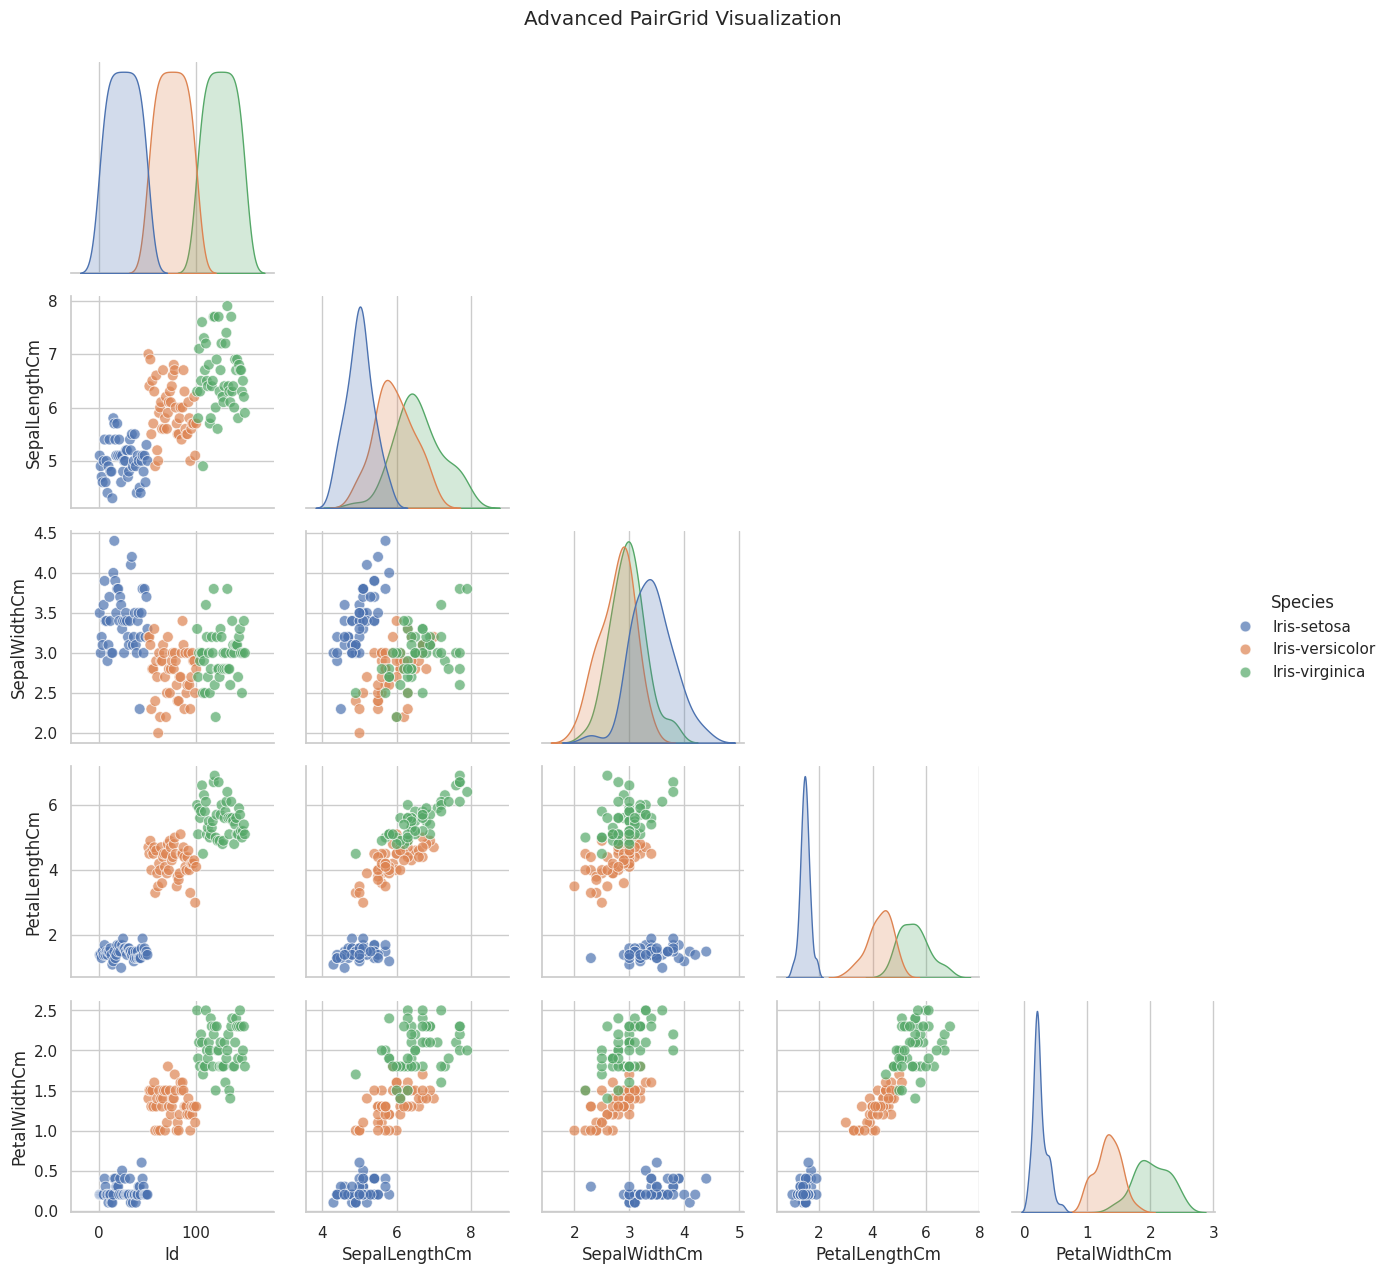

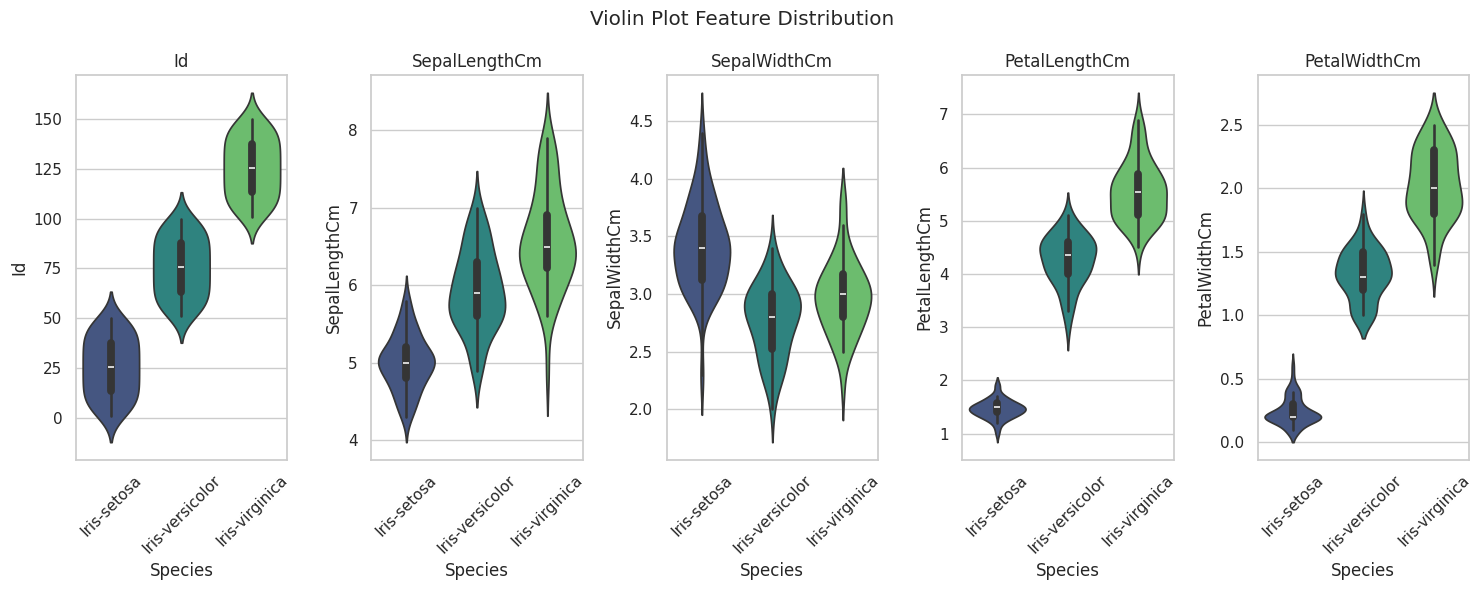


 X_train: (120, 5)
 X_test: (30, 5)

🎯 Custom Ensemble Accuracy: 1.0


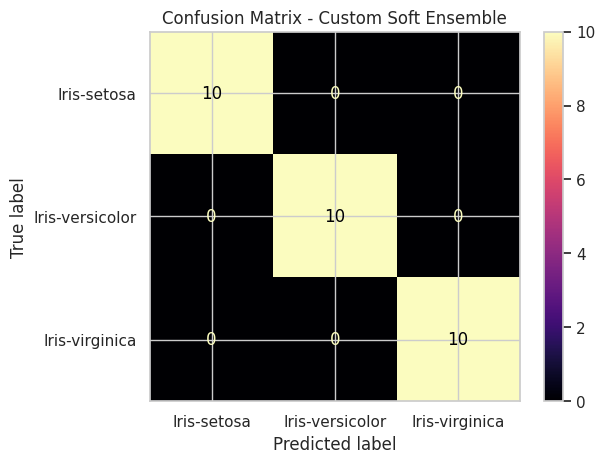


📄 Classification Report:

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      1.00      1.00        10
 Iris-virginica       1.00      1.00      1.00        10

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



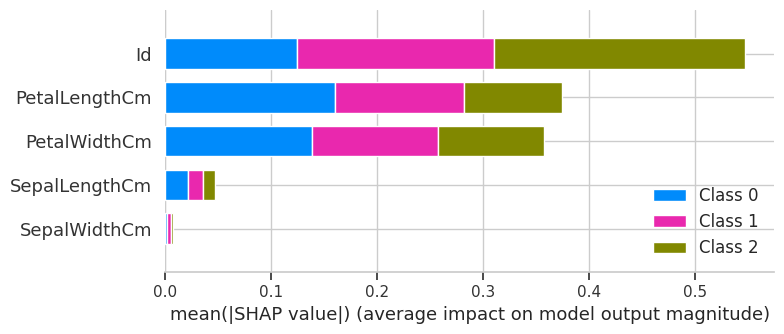


💾 Model saved as Iris_Custom_Ensemble.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# =============================================================
#  IRIS FLOWER CLASSIFICATION
# =============================================================

# ----------------------------
# 0. IMPORTS & DATA UPLOAD
# ----------------------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

print(" Upload your Iris CSV file (Iris.csv)")
uploaded = files.upload()

# Automatically detect the uploaded file
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("\n Dataset Loaded Successfully!")
display(df.head())


# ----------------------------
# 1. CLEANING & PREPROCESSING
# ----------------------------
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.columns = df.columns.str.replace(" ", "_").str.strip()

print("\n Dataset info:")
df.info()

print("\n Missing values:")
print(df.isnull().sum())


# ----------------------------
# 2. ADVANCED VISUALIZATIONS
# ----------------------------
sns.set_theme(style="whitegrid")

# ------------------------------------
# PairGrid — Advanced Scatter + KDE
# ------------------------------------
g = sns.PairGrid(df, hue="Species", diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot, alpha=0.7, s=60)
g.map_diag(sns.kdeplot, fill=True)
g.add_legend()
plt.suptitle("Advanced PairGrid Visualization", y=1.02)
plt.show()


# ------------------------------------
# CLEAN VIOLIN PLOTS (NO WARNINGS)
# ------------------------------------
plt.figure(figsize=(15, 6)) # Adjusted figure size for 5 plots

for i, col in enumerate(df.columns[:-1]):
    plt.subplot(1, 5, i + 1) # Changed from (1, 4, i + 1) to (1, 5, i + 1)
    sns.violinplot(
        data=df,
        x="Species",
        y=col,
        hue="Species",
        palette="viridis",
        legend=False
    )
    plt.title(col)
    plt.xticks(rotation=45)

plt.suptitle("Violin Plot Feature Distribution")
plt.tight_layout()
plt.show()


# ----------------------------
# 3. ENCODING & TRAIN-TEST SPLIT
# ----------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
df["Label"] = le.fit_transform(df["Species"])

X = df.drop(["Species", "Label"], axis=1)
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n X_train:", X_train.shape)
print(" X_test:", X_test.shape)


# ----------------------------
# 4. CUSTOM SOFT ENSEMBLE (UNIQUE)
# ----------------------------
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

class CustomSoftEnsemble:
    def __init__(self):
        self.m1 = RandomForestClassifier(n_estimators=100, random_state=42)
        self.m2 = GradientBoostingClassifier(random_state=42)
        self.m3 = SVC(kernel='rbf', probability=True, random_state=42)

    def fit(self, X, y):
        self.m1.fit(X, y)
        self.m2.fit(X, y)
        self.m3.fit(X, y)

    def predict(self, X):
        p1 = self.m1.predict_proba(X)
        p2 = self.m2.predict_proba(X)
        p3 = self.m3.predict_proba(X)
        avg_prob = (p1 + p2 + p3) / 3
        return np.argmax(avg_prob, axis=1)

model = CustomSoftEnsemble()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print("\n🎯 Custom Ensemble Accuracy:", accuracy_score(y_test, preds))


# ----------------------------
# 5. CONFUSION MATRIX & REPORT
# ----------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="magma")
plt.title("Confusion Matrix - Custom Soft Ensemble")
plt.show()

print("\n📄 Classification Report:\n")
print(classification_report(y_test, preds, target_names=le.classes_))


# ----------------------------
# 6. SHAP EXPLAINABILITY (IMPRESSIVE)
# ----------------------------
!pip install shap > /dev/null
import shap

explainer = shap.TreeExplainer(model.m1)   # Using RandomForest inside ensemble
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


# ----------------------------
# 7. SAVE THE MODEL
# ----------------------------
import joblib
joblib.dump(model, "Iris_Custom_Ensemble.pkl")

print("\n💾 Model saved as Iris_Custom_Ensemble.pkl")
files.download("Iris_Custom_Ensemble.pkl")